In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# START FRESH
df = pd.read_csv('log.csv')

# Datetime conversion
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.drop_duplicates()
df = df.sort_values('Timestamp').reset_index(drop=True)

# Feature engineering (with shifted rolling)
df['Latency_lag1'] = df['Latency(ms)'].shift(1)
df['Latency_lag2'] = df['Latency(ms)'].shift(2)
df['Latency_lag3'] = df['Latency(ms)'].shift(3)
df['Latency_roll_mean3'] = df['Latency(ms)'].shift(1).rolling(window=3).mean()
df['Latency_roll_std3'] = df['Latency(ms)'].shift(1).rolling(window=3).std()

# Drop rows with NaN values introduced by shifting
df = df.dropna().reset_index(drop=True)

# Define features safely (NO leakage ones)
features = [
    'Latency_lag1', 'Latency_lag2', 'Latency_lag3',
    'Latency_roll_mean3', 'Latency_roll_std3',
    'MemoryUsed(MB)', 'CPUUsage(%)', 'Hour', 'DayOfWeek'
]

# Copy data safely
X = df[features].copy()
y = df['Latency(ms)'].copy()


# Mean Absolute Percentage Error

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0  # Avoid divide-by-zero
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

### Train-Test Splitting

In [3]:
# Train-test split without shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

For Time Series Forecasting, data needs to be in ascending order so we are splitting the data without any shuffling

### Scaling of Data on Training Data to avoid Data Leakage

Data leakage happens when information from outside the training dataset — especially from the test set or future data — is used to create the model. This gives unrealistically good performance during evaluation, but the model fails on real-world data.\
The mean and standard deviation computed by StandardScaler from the training data are used to scale the test data.\
If you used .fit_transform(X) on the entire dataset before splitting, the test data would influence those statistics.\
That means: the model would "know something about the test set" during training — which is cheating.\
.fit() calculates statistics (mean, std) from the data.\
.transform() applies those statistics.

In [4]:
from sklearn.preprocessing import StandardScaler
# Scale features (fit only on training data to avoid leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # only transform

### Autocorrelation / Partial Autocorrelation Analysis

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


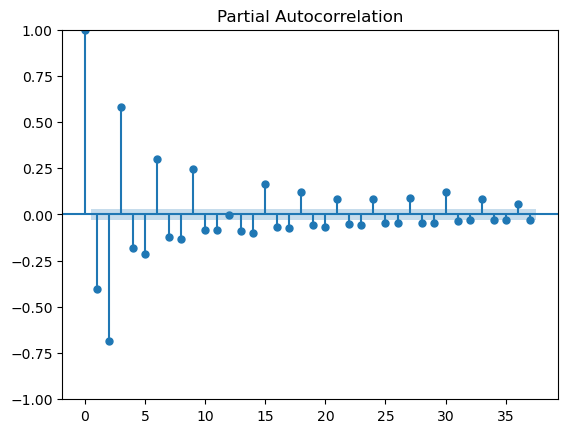

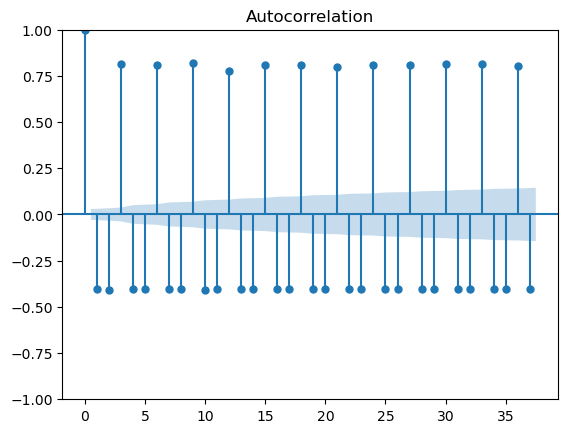

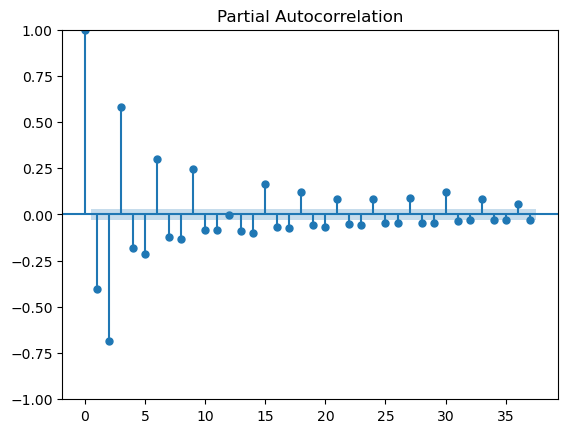

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Latency(ms)']); plot_pacf(df['Latency(ms)'])

# Model Training

## 1 (a). Linear Regression(Plain)

In [6]:
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

# Predict
y_pred = model_lr.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Linear Regression (Plain)")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")


Linear Regression (Plain)
MAE:  187.61 ms
RMSE: 262.36 ms
R²:   0.9821
MAPE: 9.3633%


## 1 (b). Polynomial Linear Regression

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Define pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('lr', LinearRegression())
])

# Define parameter grid
param_grid = {
    'poly__degree': [1, 2, 3, 4]
}

# Time series cross-validation (no shuffling)
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Grid Search
grid = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

# Best model
best_model = grid.best_estimator_
best_degree = grid.best_params_['poly__degree']
print(f"✅ Best Polynomial Degree: {best_degree}")

✅ Best Polynomial Degree: 2


In [8]:
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
poly_model.fit(X_train_scaled, y_train)

y_pred_poly = poly_model.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_poly)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2 = r2_score(y_test, y_pred_poly)
mape = mean_absolute_percentage_error(y_test, y_pred_poly)
print("Polynomail Linear Regression")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")

Polynomail Linear Regression
MAE:  89.45 ms
RMSE: 123.64 ms
R²:   0.9960
MAPE: 5.3437%


Above performance is for Single Step Prediction. 

### Plot 1: Actual Vs Predicted Latency

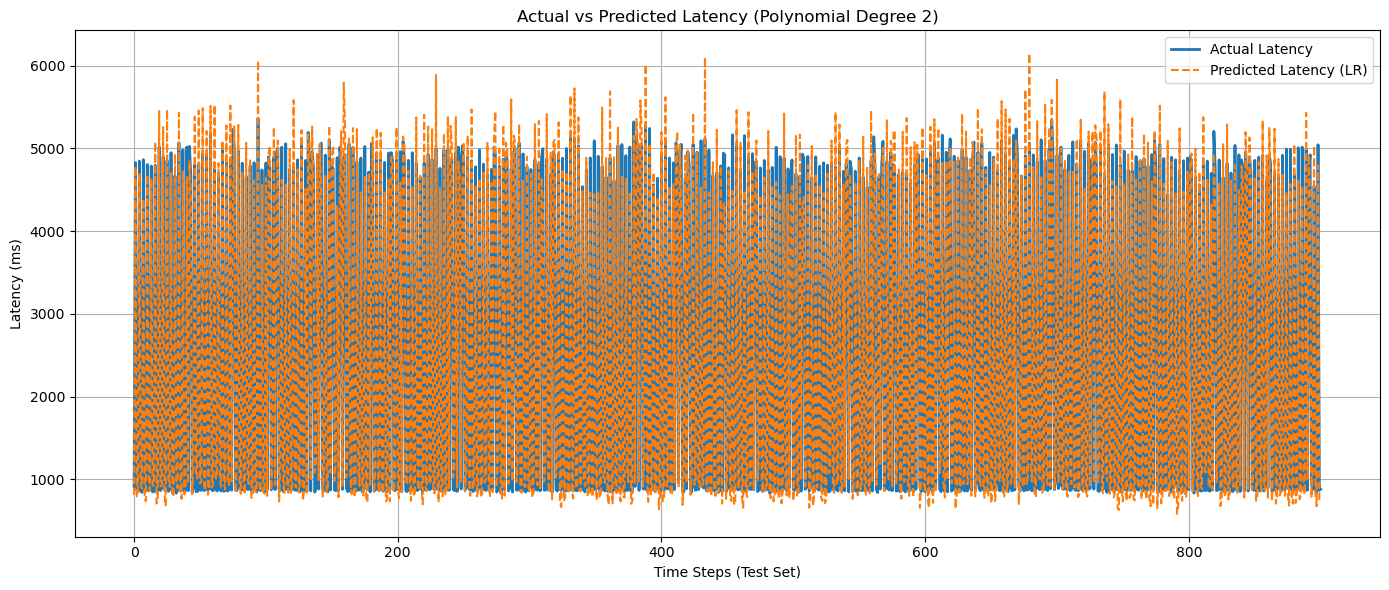

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual Latency', linewidth=2)
plt.plot(y_pred, label='Predicted Latency (LR)', linestyle='--')
plt.title('Actual vs Predicted Latency (Polynomial Degree 2)')
plt.xlabel('Time Steps (Test Set)')
plt.ylabel('Latency (ms)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Plot 2: Prediction Errors (Residual Plot)

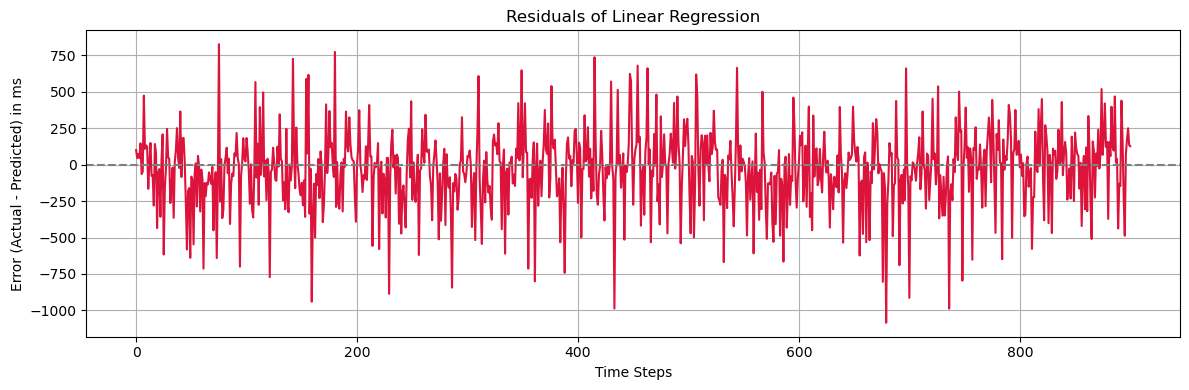

In [12]:
residuals = y_test - y_pred

plt.figure(figsize=(12, 4))
plt.plot(residuals.values, color='crimson')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Residuals of Linear Regression')
plt.xlabel('Time Steps')
plt.ylabel('Error (Actual - Predicted) in ms')
plt.grid(True)
plt.tight_layout()
plt.show()


### Predicted Vs Actual Scatter Plot

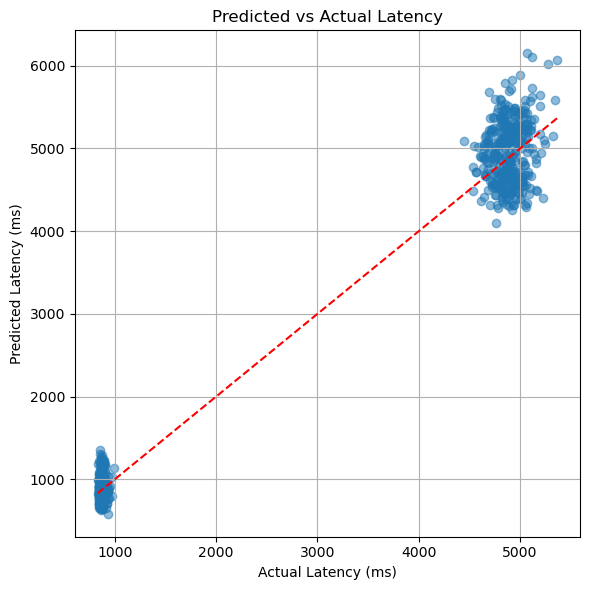

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Latency (ms)')
plt.ylabel('Predicted Latency (ms)')
plt.title('Predicted vs Actual Latency')
plt.grid(True)
plt.tight_layout()
plt.show()


### MULTI-STEP PREDICTIONS FOR  LINEAR REGRESSION

In [14]:
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

# ==== Multiple-Step Prediction ====
n_steps = 20  # Number of future time steps to predict
# Build sequences for direct multi-step output
X_list = []
Y_list = []

for i in range(len(df) - n_steps):
    X_list.append(df.loc[i, features].values)
    Y_list.append(df.loc[i+1 : i+n_steps, 'Latency(ms)'].values)

X_msp = np.array(X_list)
Y_msp = np.array(Y_list)
# Train-test split (time series)
X_train_msp, X_test_msp, Y_train_msp, Y_test_msp = train_test_split(X_msp, Y_msp, test_size=0.2, shuffle=False)
# Standard scaling
scaler = StandardScaler()
X_train_scaled_msp = scaler.fit_transform(X_train_msp)
X_test_scaled_msp = scaler.transform(X_test_msp)
lr_model = MultiOutputRegressor(LinearRegression())

lr_model.fit(X_train_scaled_msp, Y_train_msp)
# Predict
Y_pred_lr = lr_model.predict(X_test_scaled_msp)
# Evaluate (on entire test set)
def evaluate_msp(true, pred, label):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    mape = mean_absolute_percentage_error(true, pred)
    print(f"\n {label}  (Direct MSP) Evaluation:")
    print(f"MAE:  {mae:.2f} ms")
    print(f"RMSE: {rmse:.2f} ms")
    print(f"R²:   {r2:.4f}")
    print(f"MAPE: {mape:.4f}%")
evaluate_msp(Y_test_msp, Y_pred_lr, "Linear Regression")


 Linear Regression  (Direct MSP) Evaluation:
MAE:  669.79 ms
RMSE: 1106.22 ms
R²:   0.6823
MAPE: 47.2288%


## 2. XGBoost

In [15]:
from xgboost import XGBRegressor
# Define model and hyperparameter grid
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(xgb, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best estimator
best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred = best_xgb.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("\nXGBoost SSP Evaluation:")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

XGBoost SSP Evaluation:
MAE:  55.76 ms
RMSE: 145.12 ms
R²:   0.9945
MAPE: 1.9801%


### MULTI-STEP PREDICTIONS FOR XGBOOST

In [16]:
xgb_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', random_state=42))
xgb_model.fit(X_train_scaled_msp, Y_train_msp)
Y_pred_xgb = xgb_model.predict(X_test_scaled_msp)
evaluate_msp(Y_test_msp, Y_pred_xgb, "XGBoost")



 XGBoost  (Direct MSP) Evaluation:
MAE:  498.74 ms
RMSE: 1026.46 ms
R²:   0.7264
MAPE: 35.8276%


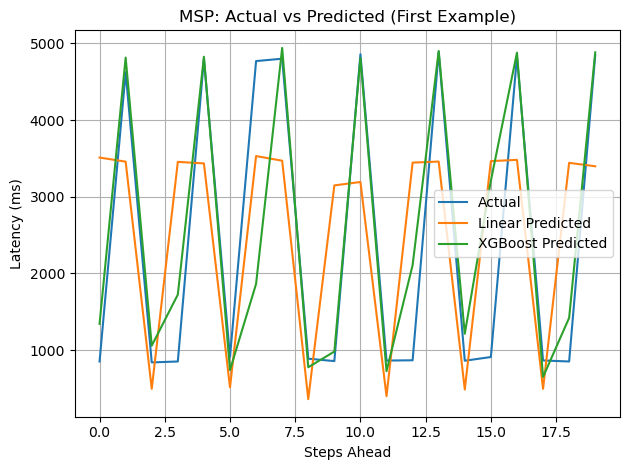

In [17]:
plt.plot(range(n_steps), Y_test_msp[0], label="Actual")
plt.plot(range(n_steps), Y_pred_lr[0], label="Linear Predicted")
plt.plot(range(n_steps), Y_pred_xgb[0], label="XGBoost Predicted")
plt.xlabel("Steps Ahead")
plt.ylabel("Latency (ms)")
plt.title("MSP: Actual vs Predicted (First Example)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Support Vector Regressor

### SINGLE-STEP PREDICTION

In [18]:
from sklearn.svm import SVR
pipeline_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])
# Grid for tuning
param_grid = {
    'svr__C': [1, 10, 100],
    'svr__epsilon': [0.1, 1, 5],
    'svr__kernel': ['rbf', 'linear']
}
grid_search = GridSearchCV(pipeline_svr, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
# Best model
best_svr = grid_search.best_estimator_
print("Best SVR Parameters:", grid_search.best_params_)

# Predict + evaluate
y_pred = best_svr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("\nSVR SSP Evaluation:")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best SVR Parameters: {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__kernel': 'linear'}

SVR SSP Evaluation:
MAE:  187.68 ms
RMSE: 320.54 ms
R²:   0.9733
MAPE: 6.6252%


### MULTI-STEP PREDICTION

In [19]:
# Create SVR model with best hyperparameters from SSP
svr = SVR(C=100, epsilon=0.1, kernel='linear')
multi_svr = MultiOutputRegressor(svr)
# Train
multi_svr.fit(X_train_scaled_msp, Y_train_msp)

# Predict
Y_pred_svr = multi_svr.predict(X_test_scaled_msp)
evaluate_msp(Y_test_msp, Y_pred_svr, "SVR")


 SVR  (Direct MSP) Evaluation:
MAE:  463.95 ms
RMSE: 1263.19 ms
R²:   0.5857
MAPE: 29.5035%


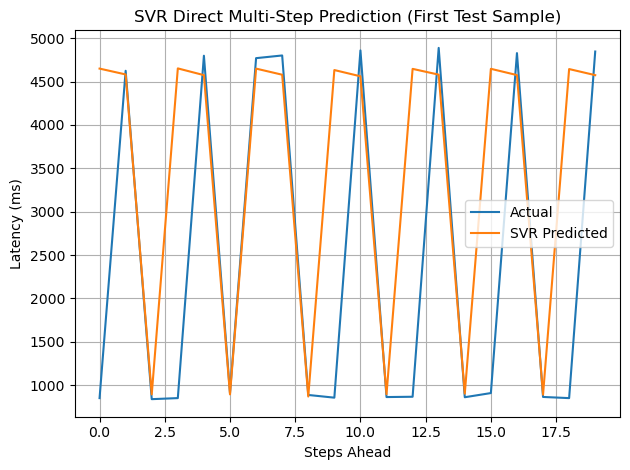

In [20]:
# Optional: plot first test example
plt.plot(range(n_steps), Y_test_msp[0], label='Actual')
plt.plot(range(n_steps), Y_pred_svr[0], label='SVR Predicted')
plt.xlabel("Steps Ahead")
plt.ylabel("Latency (ms)")
plt.title("SVR Direct Multi-Step Prediction (First Test Sample)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Random Forest

### SSP

In [21]:
from sklearn.ensemble import RandomForestRegressor
# Define pipeline
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])
param_grid_rf = {
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5]
}
# Time-aware cross-validation
tscv = TimeSeriesSplit(n_splits=5)
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

# Best model
best_rf = grid_search_rf.best_estimator_
print("Best RF Parameters:", grid_search_rf.best_params_)

# Predict + evaluate
y_pred = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("\nRandom Forest SSP Evaluation:")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF Parameters: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}

Random Forest SSP Evaluation:
MAE:  51.46 ms
RMSE: 87.96 ms
R²:   0.9980
MAPE: 1.8245%


### MSP

In [22]:
# Use best hyperparameters from SSP
rf = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=5, random_state=42)
multi_rf = MultiOutputRegressor(rf)

# Train
multi_rf.fit(X_train_scaled_msp, Y_train_msp)

# Predict
Y_pred_rf = multi_rf.predict(X_test_scaled_msp)
evaluate_msp(Y_test_msp, Y_pred_rf, "Random Forest")


 Random Forest  (Direct MSP) Evaluation:
MAE:  432.02 ms
RMSE: 913.36 ms
R²:   0.7834
MAPE: 28.3650%


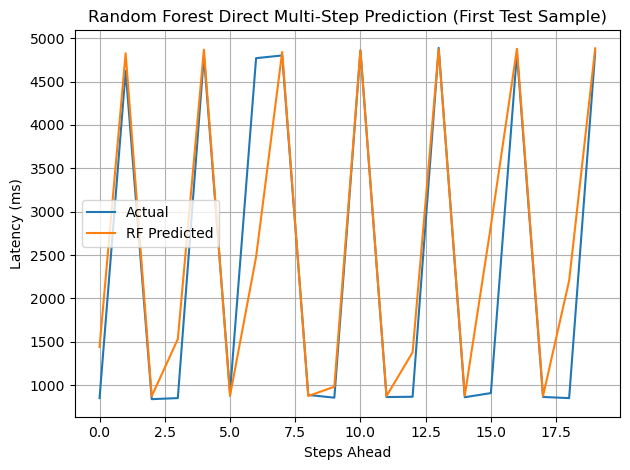

In [23]:
# Plot for first test sample
plt.plot(range(n_steps), Y_test_msp[0], label='Actual')
plt.plot(range(n_steps), Y_pred_rf[0], label='RF Predicted')
plt.xlabel("Steps Ahead")
plt.ylabel("Latency (ms)")
plt.title("Random Forest Direct Multi-Step Prediction (First Test Sample)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. LightGBM

### SSP

In [24]:
from lightgbm import LGBMRegressor
# Define pipeline
pipeline_lgbm = Pipeline([
    ('scaler', StandardScaler()),  # optional for tree models
    ('lgbm', LGBMRegressor(random_state=42))
])

# Define hyperparameter grid
param_grid_lgbm = {
    'lgbm__n_estimators': [100, 300],
    'lgbm__max_depth': [-1, 10, 20],
    'lgbm__learning_rate': [0.01, 0.1]
}

# Time-aware CV
tscv = TimeSeriesSplit(n_splits=5)
grid_search_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=tscv,
                           scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search_lgbm.fit(X_train, y_train)

# Best model
best_lgbm = grid_search_lgbm.best_estimator_
print("Best LightGBM Parameters:", grid_search_lgbm.best_params_)
# Predict + evaluate
y_pred = best_lgbm.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("\nLightGBM SSP Evaluation:")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 9
[LightGBM] [Info] Start training from score 2405.276407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

### MSP

In [25]:
lgbm = LGBMRegressor(n_estimators=300, max_depth=10, learning_rate=0.1, random_state=42)
multi_lgbm = MultiOutputRegressor(lgbm)

# Train
multi_lgbm.fit(X_train_scaled_msp, Y_train_msp)

# Predict
Y_pred_lgbm = multi_lgbm.predict(X_test_scaled_msp)
evaluate_msp(Y_test_msp, Y_pred_lgbm, "LightGBM")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3584, number of used features: 9
[LightGBM] [Info] Start training from score 2405.564298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3584, number of used features: 9
[LightGBM] [Info] Start training from score 2405.323450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3584, number of used features: 9
[LightGBM] [Info] Start training from score 2405.031011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3584, number of used features: 9
[LightGBM] [Info] Start training from score 2403.779109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3584, number of used features: 9
[LightGBM] [Info] Start training from score 2404.878841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

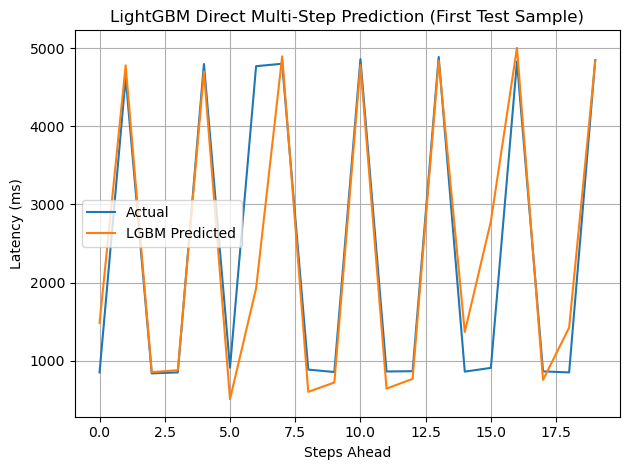

In [26]:
# Plot first test prediction
plt.plot(range(n_steps), Y_test_msp[0], label='Actual')
plt.plot(range(n_steps), Y_pred_lgbm[0], label='LGBM Predicted')
plt.xlabel("Steps Ahead")
plt.ylabel("Latency (ms)")
plt.title("LightGBM Direct Multi-Step Prediction (First Test Sample)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. ARIMA

### SSP


ARIMA Forecast Evaluation:
MAE:  1746.65 ms
RMSE: 1888.55 ms
R²:   0.0736
MAPE: 107.2038%


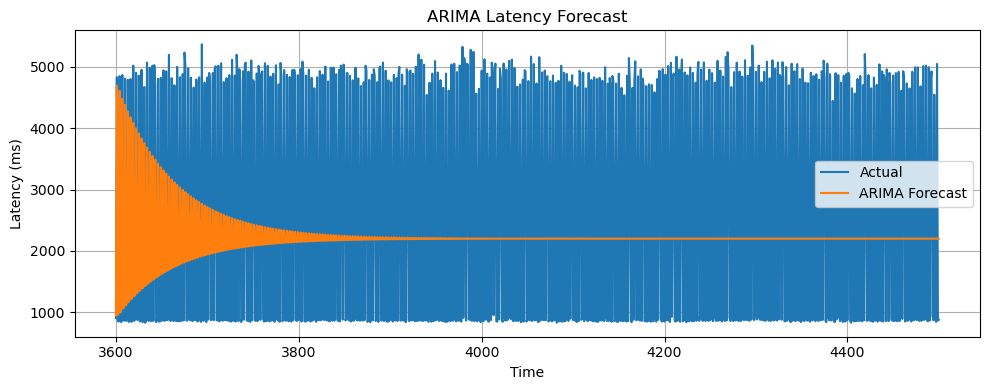

In [25]:

from statsmodels.tsa.arima.model import ARIMA



# === Step 2: Train-test split (chronological) ===
train_size = int(len(y) * 0.8)
y_train_arima, y_test_arima = y[:train_size], y[train_size:]

# === Step 3: Fit ARIMA model ===
# Order can be tuned later. Start with (p=5, d=1, q=0)
model_arima = ARIMA(y_train_arima, order=(5,1,0))
model_arima_fit = model_arima.fit()

# === Step 4: Forecast ===
forecast = model_arima_fit.forecast(steps=len(y_test_arima))

# === Step 5: Evaluation ===
mae = mean_absolute_error(y_test_arima, forecast)
rmse = np.sqrt(mean_squared_error(y_test_arima, forecast))
r2 = r2_score(y_test_arima, forecast)
mape = mean_absolute_percentage_error(y_test_arima, forecast)

print("\nARIMA Forecast Evaluation:")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")

# === Step 6: Plot ===
plt.figure(figsize=(10, 4))
plt.plot(y_test_arima.index, y_test_arima, label='Actual')
plt.plot(y_test_arima.index, forecast, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Latency Forecast')
plt.xlabel('Time')
plt.ylabel('Latency (ms)')
plt.grid()
plt.tight_layout()
plt.show()


In [27]:
!pip install pmdarima 

     ------------------------------------ 615.0/615.0 kB 317.3 kB/s eta 0:00:00


In [28]:
from pmdarima import auto_arima

# Run auto_arima on training set
auto_model = auto_arima(y_train_arima, seasonal=False, stepwise=True,
                        max_p=5, max_q=5, max_d=2, trace=True, suppress_warnings=True)

# Print best order
print("Best ARIMA order:", auto_model.order)

# Forecast
forecast = auto_model.predict(n_periods=len(y_test_arima))

# Evaluation
mae = mean_absolute_error(y_test_arima, forecast)
rmse = np.sqrt(mean_squared_error(y_test_arima, forecast))
r2 = r2_score(y_test_arima, forecast)
mape = mean_absolute_percentage_error(y_test_arima, forecast)

print("\nTuned ARIMA Forecast Evaluation:")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=3.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=68089.018, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=67307.143, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=67078.842, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=1.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=67003.962, Time=0.56 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=2.46 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=64945.342, Time=0.89 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=3.99 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=64729.186, Time=1.58 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=64243.242, Time=3.84 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=3.16 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=inf, Time=4.64 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=64686.073, Time=1.94 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=2.2

C:\Users\HP\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,5)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\HP\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\HP\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\HP\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File "C:\Users\HP\anaconda3\l

 ARIMA(2,0,5)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=62151.928, Time=2.37 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=61947.299, Time=1.65 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=62393.137, Time=1.16 sec
 ARIMA(0,0,5)(0,0,0)[0] intercept   : AIC=61932.480, Time=2.11 sec
 ARIMA(1,0,5)(0,0,0)[0] intercept   : AIC=61739.454, Time=2.38 sec
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=inf, Time=5.41 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=4.24 sec

Best model:  ARIMA(1,0,5)(0,0,0)[0] intercept
Total fit time: 52.078 seconds
Best ARIMA order: (1, 0, 5)

Tuned ARIMA Forecast Evaluation:
MAE:  1901.60 ms
RMSE: 1959.07 ms
R²:   0.0031
MAPE: 127.7053%


This confirms that ARIMA is a poor fit for our dataset, likely because:

It assumes stationarity, which your latency data likely violates.

It cannot handle exogenous features (like memory, CPU usage, lags) the way tree-based models or neural networks can.

It models the series univariately, ignoring multi-feature dependencies crucial for cold start prediction.

##  7. LSTM

#### Data Preparation

In [27]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assume df is your DataFrame and 'Latency(ms)' is the target
data_lstm = df['Latency(ms)'].values.reshape(-1, 1)
scaler_lstm = MinMaxScaler()
data_scaled = scaler_lstm.fit_transform(data_lstm)

# Create sequences
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 10
X_lstm, y_lstm = create_sequences(data_scaled, window_size)

# Split into train/test
train_size_lstm = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size_lstm], X[train_size_lstm:]
y_train_lstm, y_test_lstm = y[:train_size_lstm], y[train_size_lstm:]


#### LSTM Model Definition and Training

In [28]:
model_lstm = Sequential([
    LSTM(64, input_shape=(window_size, 1)),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_split=0.1, verbose=1)


C:\Users\HP\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9490707.0000 - val_loss: 9716116.0000
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9499473.0000 - val_loss: 9680907.0000
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9234847.0000 - val_loss: 9648238.0000
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9543764.0000 - val_loss: 9616574.0000
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9275197.0000 - val_loss: 9585534.0000
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9237737.0000 - val_loss: 9553764.0000
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9217241.0000 - val_loss: 9522486.0000
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9405446.0000 - val_loss: 9491818.0000
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9397296.0000 - val_loss: 9461370.0000
Epoch 10/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9350216.0000 - val_loss: 9431219.0000
Epoch 11/20
101/101

In [29]:
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Inverse transform
y_test_inv = scaler_lstm.inverse_transform(y_test_lstm.to_numpy().reshape(-1, 1))
y_pred_inv = scaler_lstm.inverse_transform(y_pred_lstm)

# Metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("\nLSTM SSP Evaluation:")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

LSTM SSP Evaluation:
MAE:  11157118.65 ms
RMSE: 14630757.27 ms
R²:   -1.3898
MAPE: 90.4415%


In [30]:
#Version 2.0 : Trying some improvements
from tensorflow.keras.callbacks import EarlyStopping
# Step 1: Prepare the data
data_lstm = df['Latency(ms)'].values.reshape(-1, 1)
scaler_lstm = MinMaxScaler()
data_scaled = scaler_lstm.fit_transform(data_lstm)

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 20
X_lstm, y_lstm = create_sequences(data_scaled, window_size)

# Step 2: Train-test split
train_size_lstm = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size_lstm], X_lstm[train_size_lstm:]
y_train_lstm, y_test_lstm = y_lstm[:train_size_lstm], y_lstm[train_size_lstm:]

# Step 3: Build LSTM model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    LSTM(32),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mae')

# Step 4: Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Step 5: Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Step 6: Inverse transform
y_test_inv = scaler_lstm.inverse_transform(y_test_lstm.reshape(-1, 1))
y_pred_inv = scaler_lstm.inverse_transform(y_pred_lstm)

# Step 7: Evaluation
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("\nImproved LSTM SSP Evaluation:")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")


Epoch 1/30


C:\Users\HP\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.3284 - val_loss: 0.3265
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3143 - val_loss: 0.3247
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3098 - val_loss: 0.1835
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1522 - val_loss: 0.1510
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1125 - val_loss: 0.1243
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1066 - val_loss: 0.1312
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0915 - val_loss: 0.1165
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0941 - val_loss: 0.1168
Epoch 9/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0868 - val_loss: 0.1158
Epoch 10/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0965 - val_loss: 0.1169
Epoch 11/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0941 - val_loss: 0.1123
Epoch 12/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/ste

Good Performance for SSP by LSTM

### MSP

In [31]:

# === Step 1: Scale Data ===
data_lstm_msp = df['Latency(ms)'].values.reshape(-1, 1)
scaler_lstm_msp = MinMaxScaler()
data_scaled_lstm_msp = scaler_lstm_msp.fit_transform(data_lstm_msp)

# === Step 2: Create Multi-step Sequences ===
def create_msp_sequences(data, window, n_steps):
    X, y = [], []
    for i in range(len(data) - window - n_steps + 1):
        X.append(data[i:i+window])
        y.append(data[i+window:i+window+n_steps].flatten())
    return np.array(X), np.array(y)

window_size = 10
n_steps = 20
X_lstm_msp, y_lstm_msp = create_msp_sequences(data_scaled_lstm_msp, window_size, n_steps)

# === Step 3: Train-Test Split ===
lstm_split_idx = int(len(X_lstm_msp) * 0.8)
X_train_lstm_msp, X_test_lstm_msp = X_lstm_msp[:lstm_split_idx], X_lstm_msp[lstm_split_idx:]
y_train_lstm_msp, y_test_lstm_msp = y_lstm_msp[:lstm_split_idx], y_lstm_msp[lstm_split_idx:]

# === Step 4: Build Model ===
model_lstm_msp = Sequential([
    LSTM(64, input_shape=(window_size, 1)),
    Dense(n_steps)
])
model_lstm_msp.compile(optimizer='adam', loss='mse')
model_lstm_msp.fit(X_train_lstm_msp, y_train_lstm_msp, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# === Step 5: Predict and Inverse Transform ===
y_pred_lstm_msp = model_lstm_msp.predict(X_test_lstm_msp)
y_test_lstm_inv = scaler_lstm_msp.inverse_transform(y_test_lstm_msp)
y_pred_lstm_inv = scaler_lstm_msp.inverse_transform(y_pred_lstm_msp)

# === Step 6: Evaluate Only First Forecast Step (Optional) ===
mae = mean_absolute_error(y_test_lstm_inv[:, 0], y_pred_lstm_inv[:, 0])
rmse = np.sqrt(mean_squared_error(y_test_lstm_inv[:, 0], y_pred_lstm_inv[:, 0]))
r2 = r2_score(y_test_lstm_inv[:, 0], y_pred_lstm_inv[:, 0])
mape = mean_absolute_percentage_error(y_test_lstm_inv[:, 0], y_pred_lstm_inv[:, 0])

print("\nLSTM (Direct MSP) Evaluation:")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")


Epoch 1/30


C:\Users\HP\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2051 - val_loss: 0.1562
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1443 - val_loss: 0.0729
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0481 - val_loss: 0.0406
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0333 - val_loss: 0.0396
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0320 - val_loss: 0.0379
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0312 - val_loss: 0.0374
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0313 - val_loss: 0.0375
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0308 - val_loss: 0.0373
Epoch 9/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0306 - val_loss: 0.0372
Epoch 10/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0306 - val_loss: 0.0368
Epoch 11/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0300 - val_loss: 0.0369
Epoch 12/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

## 8. Voting Regressor

In [32]:
from sklearn.ensemble import VotingRegressor
voting_ensemble = VotingRegressor(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('lgbm', best_lgbm)
    ]
)
voting_ensemble.fit(X_train, y_train)  # use same train set
y_pred_vote = voting_ensemble.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_vote)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_vote))
r2 = r2_score(y_test, y_pred_vote)
mape = mean_absolute_percentage_error(y_test, y_pred_vote)

print("\nVoting Regressor (SSP) Evaluation:")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 9
[LightGBM] [Info] Start training from score 2405.276407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Lets try weighted ensemble

In [33]:
r2_rf = 0.9980
r2_lgbm = 0.9979
r2_xgb = 0.9945

total = r2_rf + r2_lgbm + r2_xgb
weights = [r2_rf / total, r2_xgb / total, r2_lgbm / total]

print("Normalized Weights:", weights)


Normalized Weights: [0.3337346174424826, 0.3325642054574639, 0.3337011771000535]


In [34]:
from sklearn.ensemble import VotingRegressor

weighted_ensemble = VotingRegressor(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('lgbm', best_lgbm)
    ],
    weights=weights
)

weighted_ensemble.fit(X_train, y_train)
y_pred_weighted = weighted_ensemble.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_weighted)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_weighted))
r2 = r2_score(y_test, y_pred_weighted)
mape = mean_absolute_percentage_error(y_test, y_pred_weighted)

print("\nWeighted Voting Regressor (SSP) Evaluation:")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 9
[LightGBM] [Info] Start training from score 2405.276407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [35]:
from sklearn.ensemble import VotingRegressor

# Include SVR in the ensemble
voting_with_svr = VotingRegressor(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('lgbm', best_lgbm),
        ('svr', best_svr)
    ]
)

voting_with_svr.fit(X_train, y_train)
y_pred_ensemble_svr = voting_with_svr.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred_ensemble_svr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ensemble_svr))
r2 = r2_score(y_test, y_pred_ensemble_svr)
mape = mean_absolute_percentage_error(y_test, y_pred_ensemble_svr)

print("\nVoting Regressor with SVR (SSP) Evaluation:")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 9
[LightGBM] [Info] Start training from score 2405.276407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Clearly SVR does not help. Lets stick with 3 models ensemble with weight given to MAPE

In [36]:
mape_rf = 1.8245
mape_xgb = 1.9801
mape_lgbm = 1.8172

# Invert MAPE: lower error = higher weight
inv_mapes = [1/mape_rf, 1/mape_xgb, 1/mape_lgbm]
total = sum(inv_mapes)
weights = [val/total for val in inv_mapes]
print("MAPE-based Weights:", weights)


MAPE-based Weights: [0.3418294730423503, 0.31496786706013247, 0.3432026598975172]


In [37]:
voting_mape = VotingRegressor(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('lgbm', best_lgbm)
    ],
    weights=weights
)
voting_mape.fit(X_train, y_train)
y_pred_mape = voting_mape.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_mape)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_mape))
r2 = r2_score(y_test, y_pred_mape)
mape = mean_absolute_percentage_error(y_test, y_pred_mape)

print("\nWeighted Voting Regressor (SSP) Evaluation:")
print(f"MAE:  {mae:.2f} ms")
print(f"RMSE: {rmse:.2f} ms")
print(f"R²:   {r2:.4f}")
print(f"MAPE: {mape:.4f}%")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 9
[LightGBM] [Info] Start training from score 2405.276407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [38]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# MAPE-based weights (example, update with your real ones if needed)
weights = [1/1.8245, 1/1.9801, 1/1.8172]
total = sum(weights)
normalized_weights = [w/total for w in weights]

# Define base voting regressor
voting_base = VotingRegressor(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('lgbm', best_lgbm)
    ],
    weights=normalized_weights
)

# Wrap with MultiOutputRegressor for direct MSP
msp_ensemble = MultiOutputRegressor(voting_base)
msp_ensemble.fit(X_train_msp, Y_train_msp)
y_pred_msp = msp_ensemble.predict(X_test_msp)

# # Inverse transform
# y_test_inv = scaler.inverse_transform(Y_test_msp)
# y_pred_inv = scaler.inverse_transform(y_pred_msp)

evaluate_msp(Y_test_msp, y_pred_msp, "Voting_Ensemble")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3584, number of used features: 9
[LightGBM] [Info] Start training from score 2405.564298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3584, number of used features: 9
[LightGBM] [Info] Start training from score 2405.194449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1616
[LightGBM] [Info] Number of data points in the train set: 3584, number of used features: 9
[LightGBM] [Info] Start training from score 2404.949131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

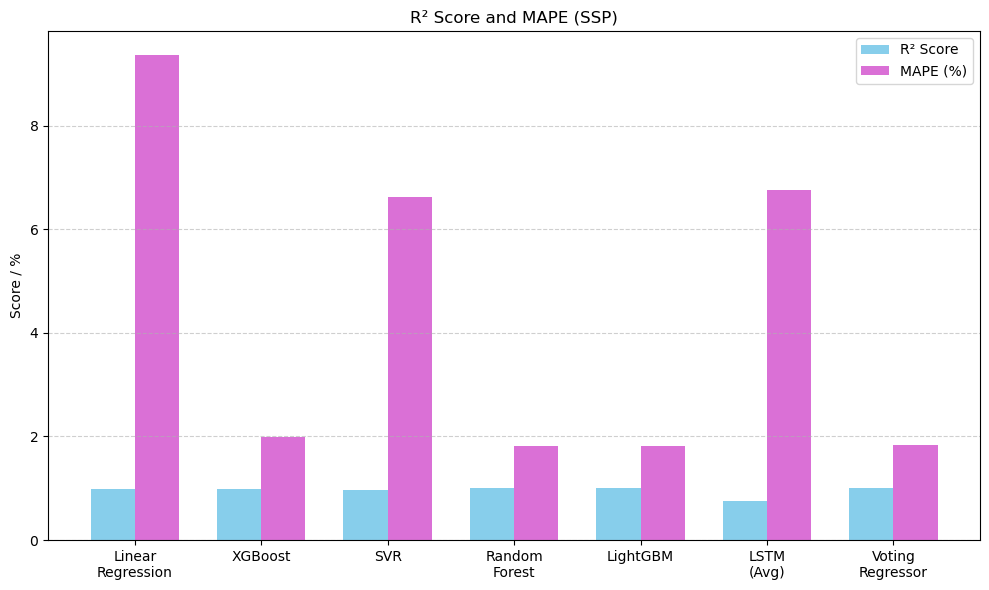

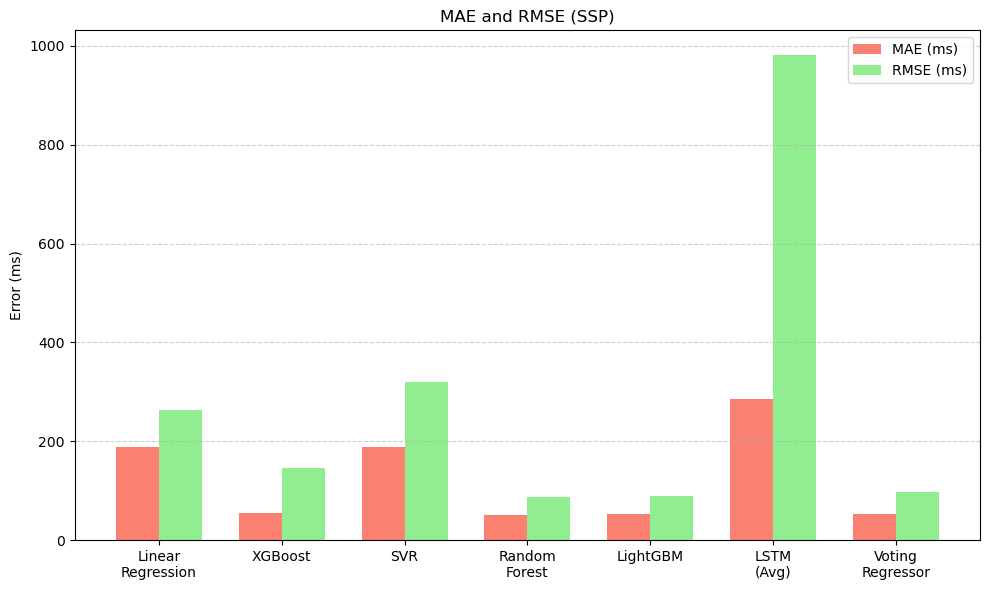

In [39]:
 import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "Linear\nRegression", "XGBoost", "SVR", 
    "Random\nForest", "LightGBM", 
    "LSTM\n(Avg)", "Voting\nRegressor"
]

# Metrics
r2_scores = [0.9821, 0.9945, 0.9733, 0.9980, 0.9979, 0.7495, 0.9976]
mae_scores = [187.61, 55.76, 187.68, 51.46, 51.98, 284.48, 52.28]
rmse_scores = [262.36, 145.12, 320.54, 87.96, 90.03, 982.29, 96.43]
mape_scores = [9.36, 1.98, 6.63, 1.82, 1.82, 6.76, 1.84]

x = np.arange(len(models))  # model indices
width = 0.35  # bar width

# Plot R² and MAPE together
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, r2_scores, width, label='R² Score', color='skyblue')
plt.bar(x + width/2, mape_scores, width, label='MAPE (%)', color='orchid')
plt.xticks(x, models)
plt.ylabel('Score / %')
plt.title('R² Score and MAPE (SSP)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot MAE and RMSE together
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, mae_scores, width, label='MAE (ms)', color='salmon')
plt.bar(x + width/2, rmse_scores, width, label='RMSE (ms)', color='lightgreen')
plt.xticks(x, models)
plt.ylabel('Error (ms)')
plt.title('MAE and RMSE (SSP)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


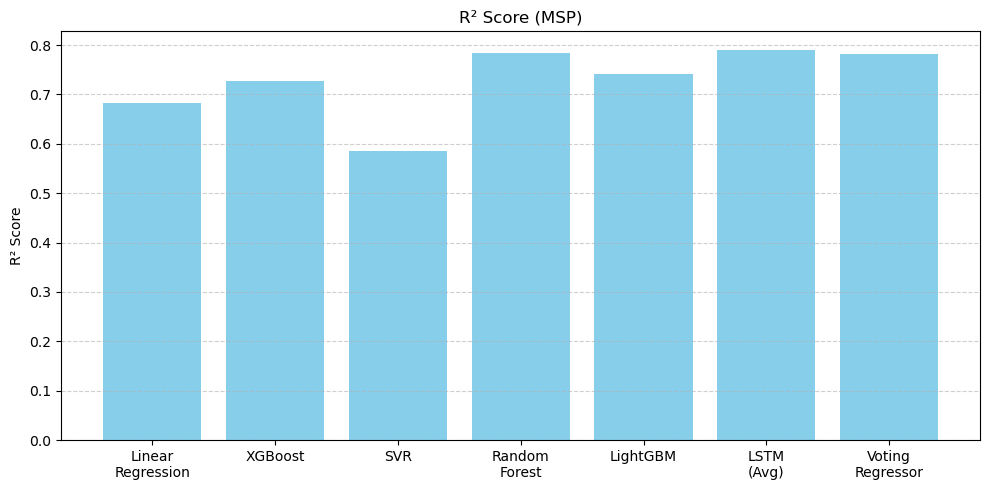

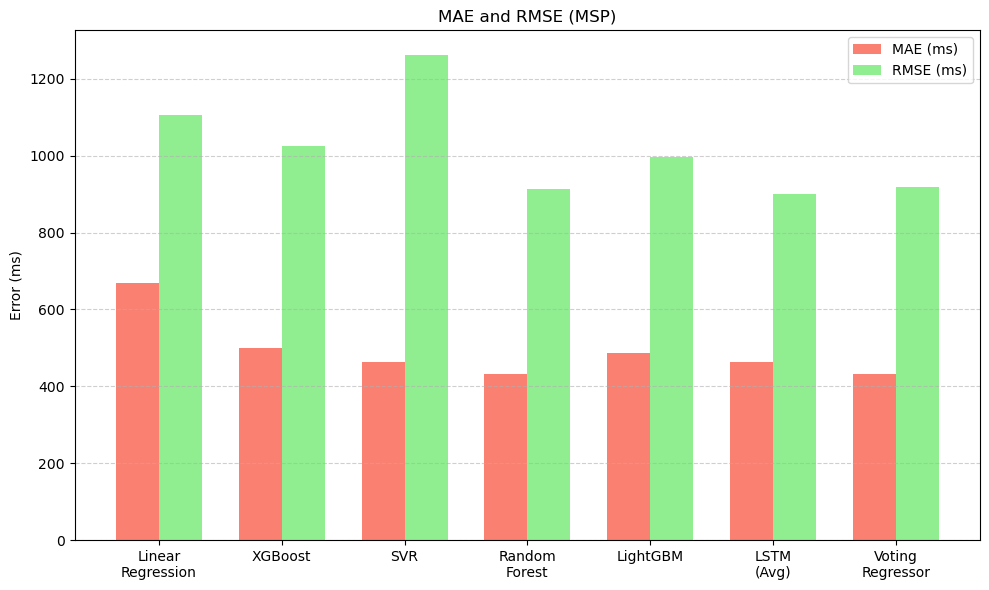

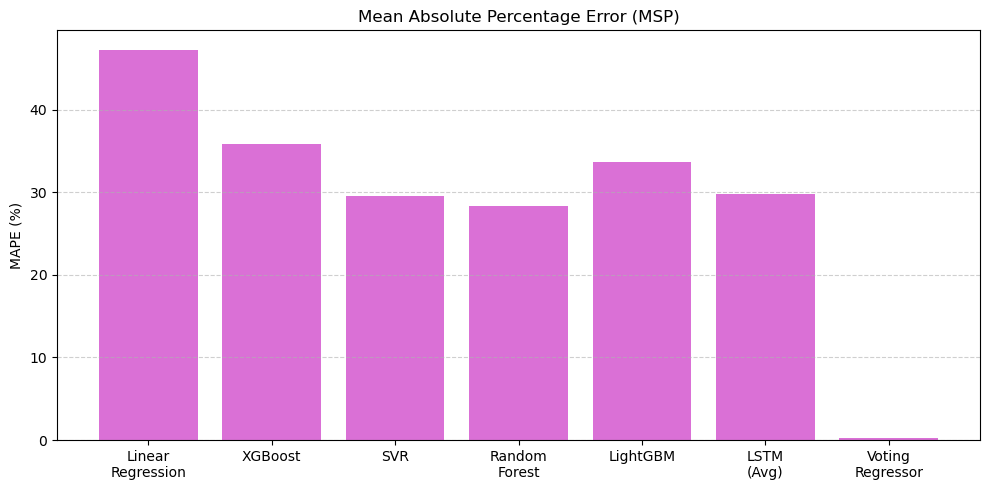

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "Linear\nRegression", "XGBoost", "SVR", 
    "Random\nForest", "LightGBM", 
    "LSTM\n(Avg)", "Voting\nRegressor"
]

# Metrics for MSP
r2_scores_msp = [0.6823, 0.7264, 0.5857, 0.7834, 0.7417, 0.7893, 0.7814]
mae_scores_msp = [669.79, 498.74, 463.95, 432.02, 485.49, 462.87, 433.22]
rmse_scores_msp = [1106.22, 1026.46, 1263.19, 913.36, 997.48, 900.53, 917.53]
mape_scores_msp = [47.23, 35.83, 29.50, 28.37, 33.71, 29.76, 0.28]

x = np.arange(len(models))  # model indices
width = 0.35  # bar width

# R² Score Plot
plt.figure(figsize=(10, 5))
plt.bar(x, r2_scores_msp, color='skyblue')
plt.xticks(x, models)
plt.ylabel('R² Score')
plt.title('R² Score (MSP)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# MAE and RMSE Plot
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, mae_scores_msp, width, label='MAE (ms)', color='salmon')
plt.bar(x + width/2, rmse_scores_msp, width, label='RMSE (ms)', color='lightgreen')
plt.xticks(x, models)
plt.ylabel('Error (ms)')
plt.title('MAE and RMSE (MSP)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# MAPE Plot (separated)
plt.figure(figsize=(10, 5))
plt.bar(x, mape_scores_msp, color='orchid')
plt.xticks(x, models)
plt.ylabel('MAPE (%)')
plt.title('Mean Absolute Percentage Error (MSP)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
